In [7]:
import os
from pathlib import Path

import numpy as np
import omegaconf
import pandas as pd
import tensorflow as tf

import keras

import sys
sys.path.append('../')

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from src.base_model import build_model
from src.data import generate_data, generate_test_data

In [46]:
chkpt_dir = "/home/qbeer/GitHub/ai4covid/data/raw_output/checkpoints/2022-02-24_15:16:44.629240"

config_path = Path(chkpt_dir) / "config.yaml"
config = omegaconf.OmegaConf.load(config_path)

model = build_model(config=config)

checkpoint_path = Path(chkpt_dir) / "cp.ckpt"
model.load_weights(checkpoint_path).expect_partial()

prediction_model = tf.keras.models.Model(
    [
        model.get_layer(name="image").input,
        model.get_layer(name="fourier").input,
        model.get_layer(name="brixia").input,
        model.get_layer(name="mask").input,
        model.get_layer(name="meta").input,
    ],
    model.get_layer(name="prognosis_out").output,
)

prediction_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
fourier (InputLayer)            [(None, 454, 454, 1) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 224, 224, 16) 800         fourier[0][0]                    
__________________________________________________________________________________________________
fourier_bn1 (BatchNormalization (None, 224, 224, 16) 64          conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 111, 111, 32) 4640        fourier_bn1[0][0]                
____________________________________________________________________________________________

In [47]:
for layer in prediction_model.layers:
    if type(layer) == keras.engine.functional.Functional:
        for lay in layer.layers:
            if type(lay) == tf.keras.layers.Conv2D:
                break
        first_conv = lay
        print(first_conv.get_config())
        for weight in first_conv.get_weights():
            # only image filters
            image_filters = weight[:, :, 0, :]
            print(image_filters.shape)
            break

{'name': 'conv1_conv', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (7, 7), 'strides': (2, 2), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
(7, 7, 64)


In [48]:
import matplotlib.pyplot as plt

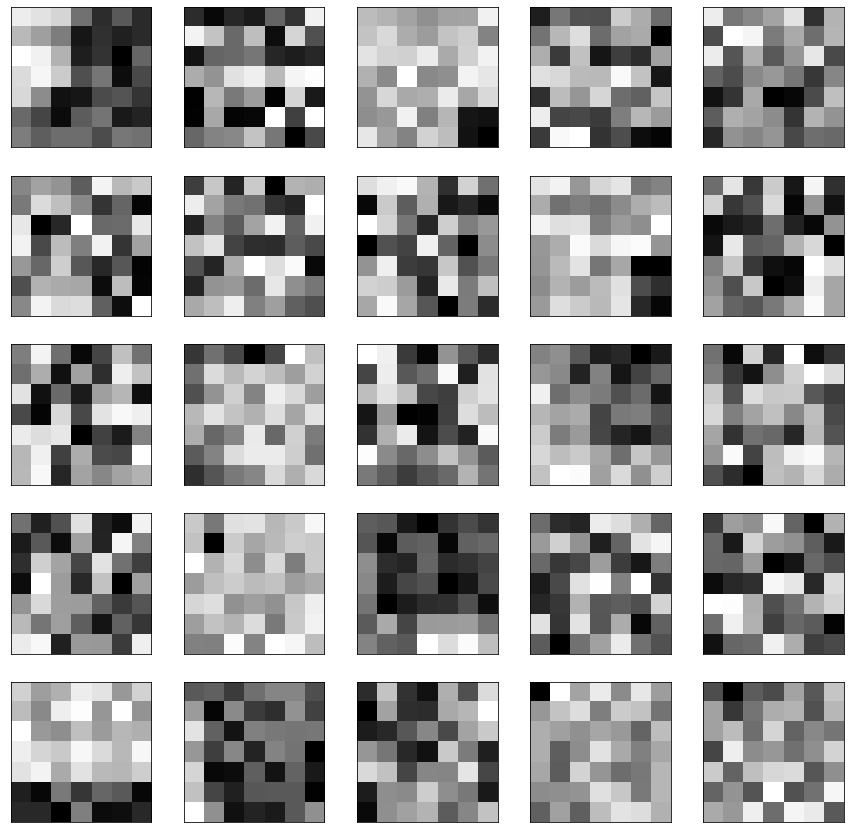

In [49]:
_, axes = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(15, 15))

for ind, ax in enumerate(axes.flatten()):
    ax.imshow(image_filters[:, :, ind].reshape(7, 7), cmap='gray', interpolation=None)
    ax.set_xticks([])
    ax.set_yticks([])